## Load the gdf

/home/mahmoud/miniconda3/envs/book/lib/python3.12/site-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/home/mahmoud/miniconda3/envs/book/lib/python3.12/site-packages/geopandas/io/sql.py:473: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


<Axes: >

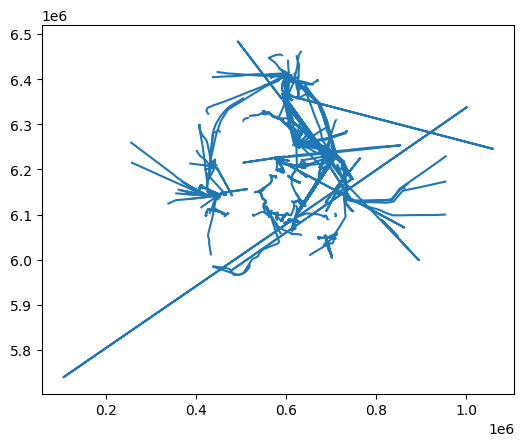

In [11]:
import psycopg2
import geopandas as gpd
from shapely.wkb import loads
import numpy as np

# Connect to PostgreSQL
connection = psycopg2.connect(
    host="localhost",
    database="aiscompression",
    user="mahmoud",
    password="pass"
)

# Query to get trips as LineStrings
query = "SELECT mmsi, tripid, traj FROM tripsByHarbours"
gdf = gpd.read_postgis(query, connection, geom_col="traj")

# Close connection
connection.close()

# plot
gdf.plot()

In [ ]:
## Cluster using Frechet distance

In [12]:
import pandas as pd
from sklearn.cluster import DBSCAN  # Import DBSCAN

# Connect to PostgreSQL
connection = psycopg2.connect(
    host="localhost",
    database="aiscompression",
    user="mahmoud",
    password="pass"
)

cursor = connection.cursor()

# Query to get the Frechet distances as a DataFrame
query = """
    SELECT mmsi1, tripid1, mmsi2, tripid2, dist
    FROM FrechetMatrix
"""
distance_df = pd.read_sql(query, connection)

# Convert the distance DataFrame into a distance matrix suitable for DBSCAN
unique_trips = sorted(set(distance_df["tripid1"]).union(set(distance_df["tripid2"])))
trip_index = {trip_id: i for i, trip_id in enumerate(unique_trips)}
n = len(unique_trips)
distance_matrix = np.full((n, n), np.inf)

for _, row in distance_df.iterrows():
    i, j = trip_index[row["tripid1"]], trip_index[row["tripid2"]]
    distance_matrix[i, j] = row["dist"]
    distance_matrix[j, i] = row["dist"]

# Apply DBSCAN using the distance matrix
epsilon = 10000  # Adjust based on distance units
min_samples = 2
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)

# Map results back to trip IDs
cluster_results = pd.DataFrame({
    "tripid": unique_trips,
    "cluster": clusters
})

# Add the 'cluster' column if it hasn't been added already
cursor.execute("""
    ALTER TABLE tripsByHarbours
    ADD COLUMN IF NOT EXISTS cluster INTEGER;
""")
connection.commit()

# Update the 'cluster' column in 'tripsByHarbours' based on the clustering results
for _, row in cluster_results.iterrows():
    tripid = row["tripid"]
    cluster = row["cluster"]
    cursor.execute("""
        UPDATE tripsByHarbours
        SET cluster = %s
        WHERE tripid = %s
    """, (int(cluster), int(tripid)))

# Commit the changes and close the connection
connection.commit()
cursor.close()
connection.close()

print(cluster_results)


/tmp/ipykernel_240544/2551781002.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  distance_df = pd.read_sql(query, connection)


      tripid  cluster
0    2860021       -1
1    2860022        0
2    2860024        1
3    2860025       -1
4    2860027       -1
..       ...      ...
548  2861087       -1
549  2861089       -1
550  2861092        2
551  2861093       -1
552  2861095       -1

[553 rows x 2 columns]


In [13]:
import pandas as pd
from sklearn.cluster import DBSCAN  # Import DBSCAN

# Connect to PostgreSQL
connection = psycopg2.connect(
    host="localhost",
    database="aiscompression",
    user="mahmoud",
    password="pass"
)

cursor = connection.cursor()

# Query to get the Frechet distances as a DataFrame
query = """
    SELECT mmsi1, tripid1, mmsi2, tripid2, dist
    FROM DTWMatrix
"""
distance_df = pd.read_sql(query, connection)

# Convert the distance DataFrame into a distance matrix suitable for DBSCAN
unique_trips = sorted(set(distance_df["tripid1"]).union(set(distance_df["tripid2"])))
trip_index = {trip_id: i for i, trip_id in enumerate(unique_trips)}
n = len(unique_trips)
distance_matrix = np.full((n, n), np.inf)

for _, row in distance_df.iterrows():
    i, j = trip_index[row["tripid1"]], trip_index[row["tripid2"]]
    distance_matrix[i, j] = row["dist"]
    distance_matrix[j, i] = row["dist"]

# Apply DBSCAN using the distance matrix
epsilon = 10000  # Adjust based on distance units
min_samples = 2
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)

# Map results back to trip IDs
cluster_results = pd.DataFrame({
    "tripid": unique_trips,
    "cluster": clusters
})

# Add the 'cluster' column if it hasn't been added already
cursor.execute("""
    ALTER TABLE tripsByHarbours
    ADD COLUMN IF NOT EXISTS clusterDTW INTEGER;
""")
connection.commit()

# Update the 'cluster' column in 'tripsByHarbours' based on the clustering results
for _, row in cluster_results.iterrows():
    tripid = row["tripid"]
    cluster = row["cluster"]
    cursor.execute("""
        UPDATE tripsByHarbours
        SET clusterDTW = %s
        WHERE tripid = %s
    """, (int(cluster), int(tripid)))

# Commit the changes and close the connection
connection.commit()
cursor.close()
connection.close()

print(cluster_results)


/tmp/ipykernel_240544/948192744.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  distance_df = pd.read_sql(query, connection)


      tripid  cluster
0    2860021       -1
1    2860022       -1
2    2860024       -1
3    2860025       -1
4    2860027       -1
..       ...      ...
548  2861087       -1
549  2861089       -1
550  2861092       -1
551  2861093       -1
552  2861095       -1

[553 rows x 2 columns]
